In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import numpy as np
import statsmodels.tsa.api as sm
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Loading the base dataset

In [2]:
def tsplot(y, lags=50, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

### Integrating with Retail and F&B sales data

In [85]:
df = pd.read_excel("Data/NEER_Economic_Indicators.xlsx")
df.head()

,date,neer,total_domestic_exports,f&b_sales,retail_sales_value,cpi_adjusted,total_merchandise_imports
0,2021-01-11,114.565,22659044,607,3441,90.214,37583825
1,2021-02-11,114.870,19710774,595,2553,90.261,32126643
2,2021-03-11,114.925,24934088,604,3071,90.341,43060778
3,2021-04-11,115.808,23029646,603,3063,91.316,38518652
4,2021-05-11,116.310,22893768,643,3187,91.182,39756662


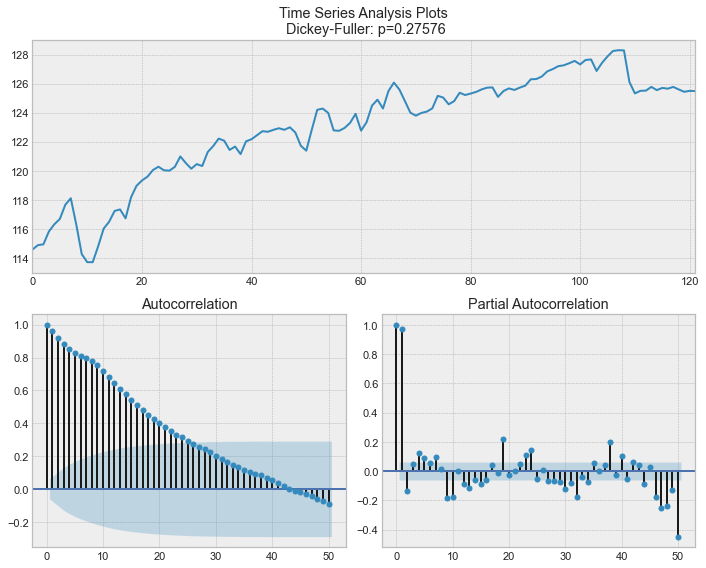

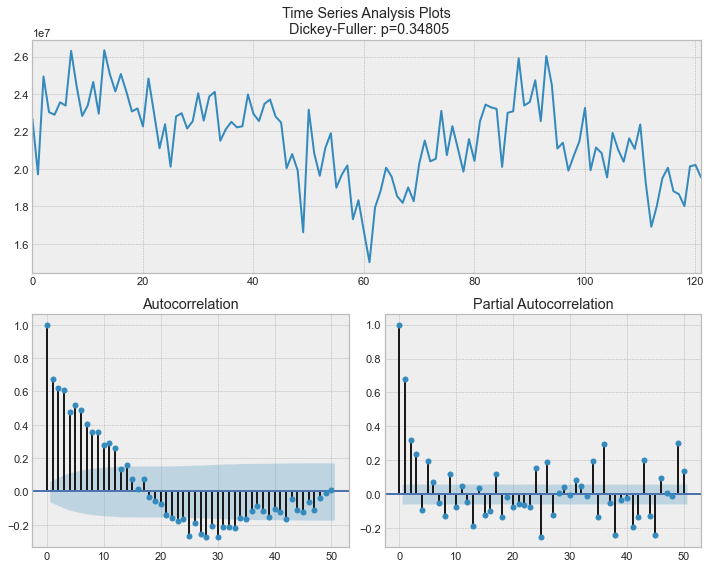

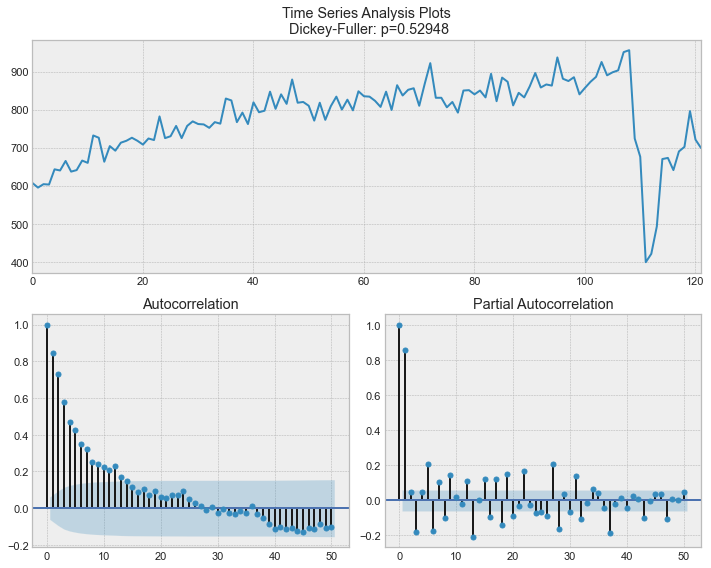

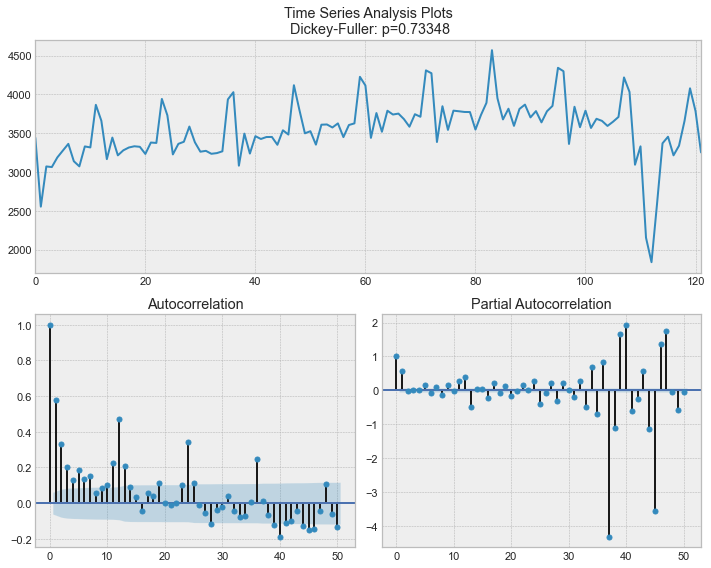

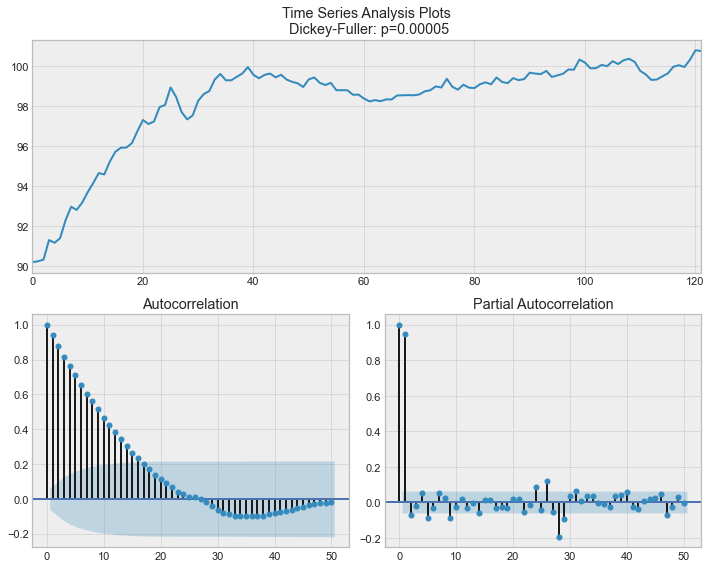

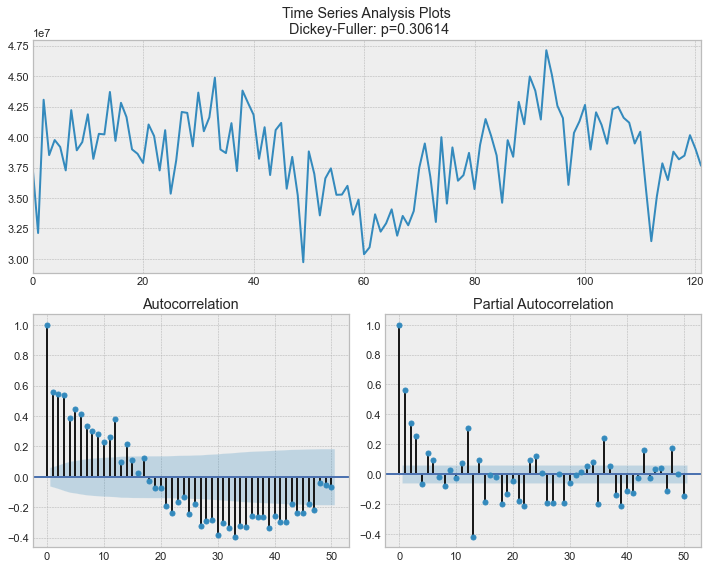

In [78]:
focused_columns = ['neer','total_domestic_exports','f&b_sales','retail_sales_value','cpi_adjusted','total_merchandise_imports']
for column in focused_columns:
    tsplot(df[column])

## Log Transformation

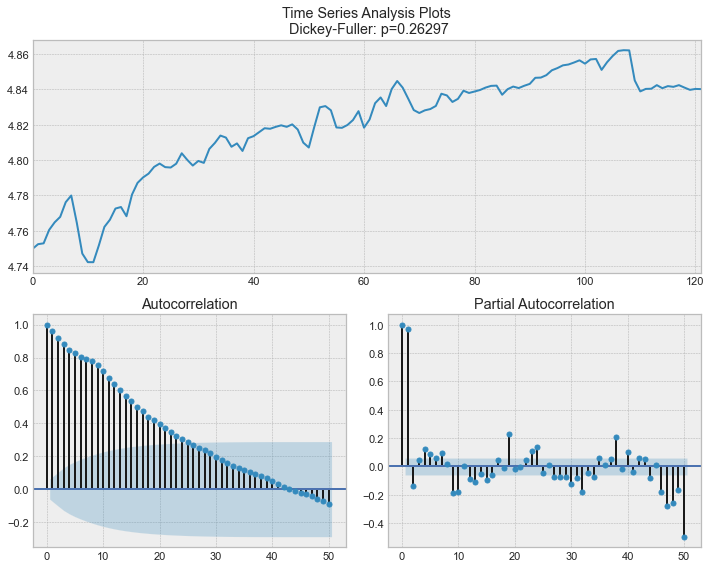

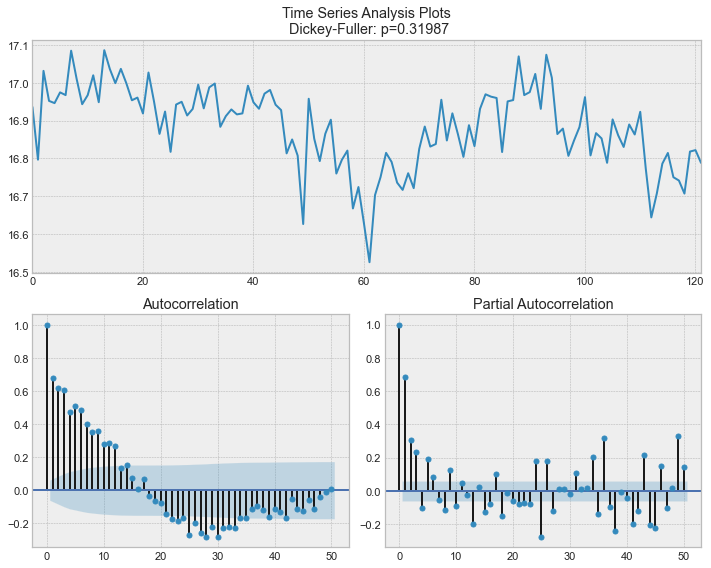

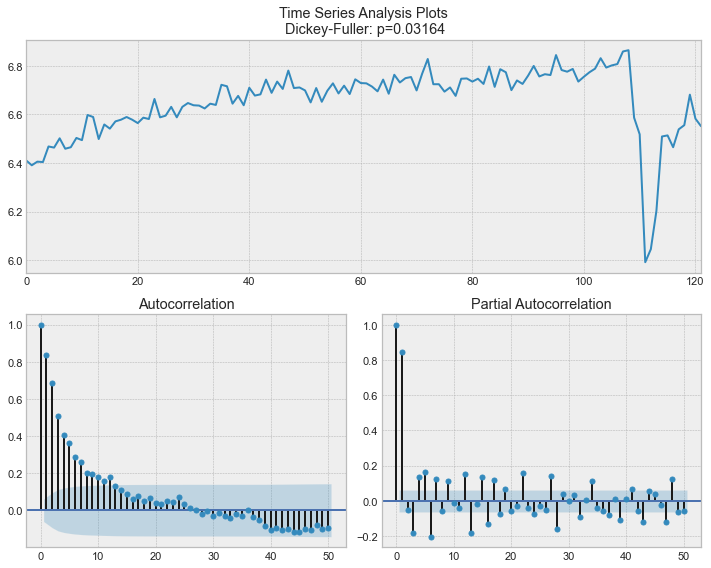

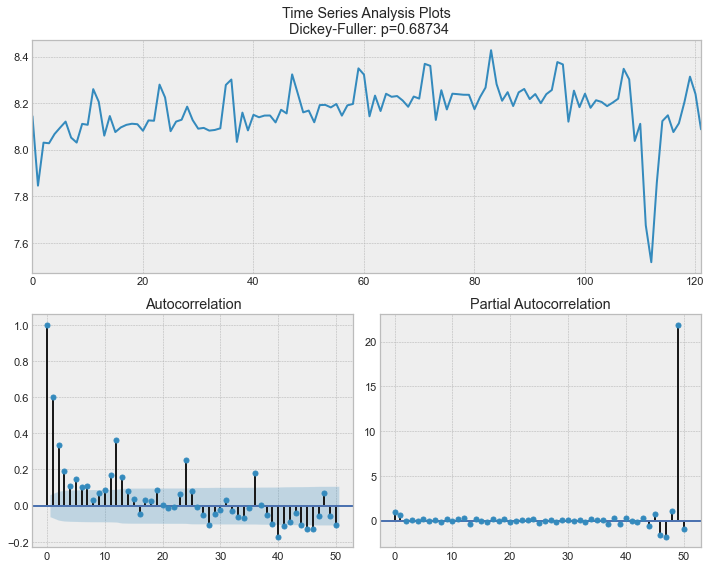

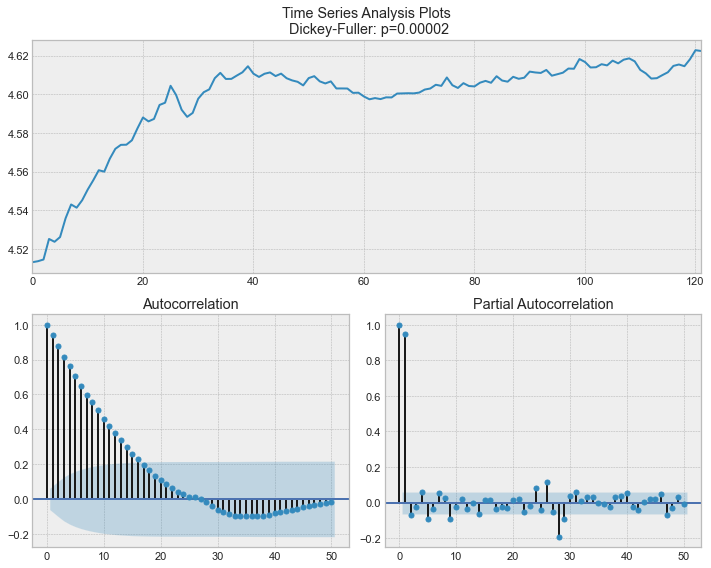

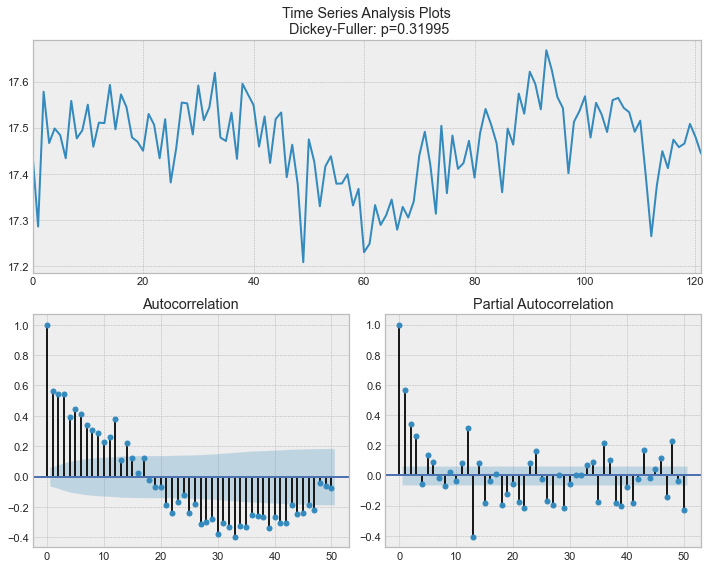

In [86]:
# data processing
for column in focused_columns:
    if column in df.columns.values.tolist():
        df[column] = np.log(df[column]+1) 
        tsplot(df[column])
        

## Differencing

In [87]:
df = df[focused_columns].diff().dropna()

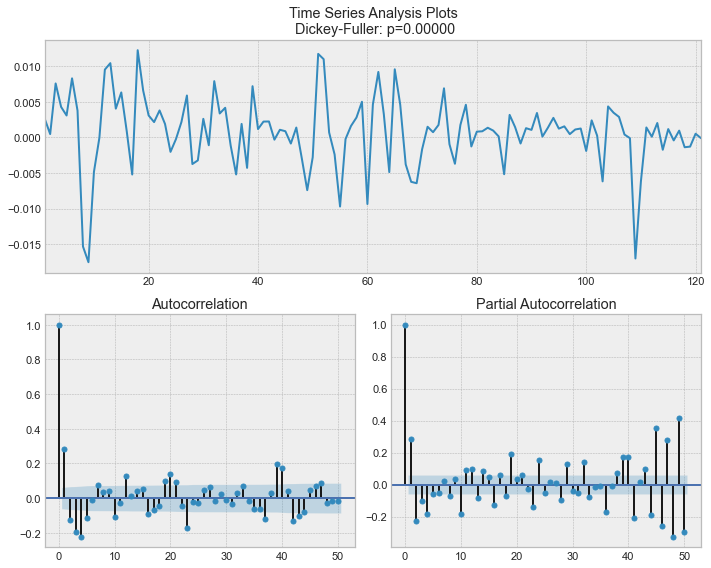

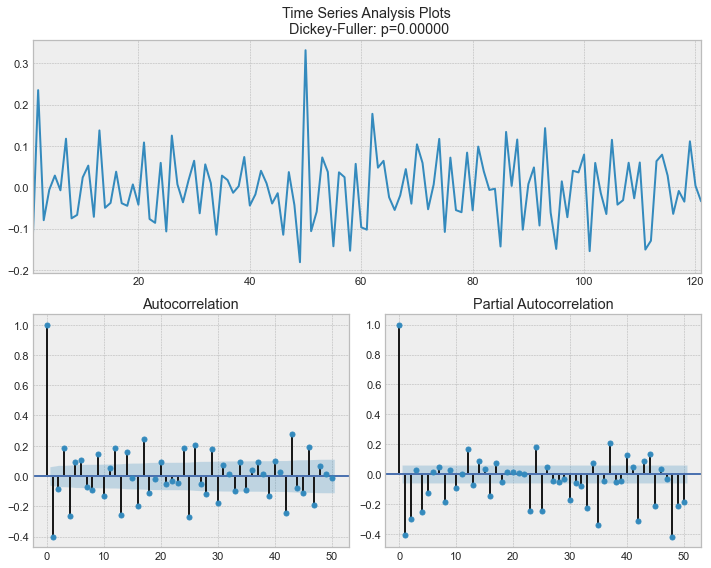

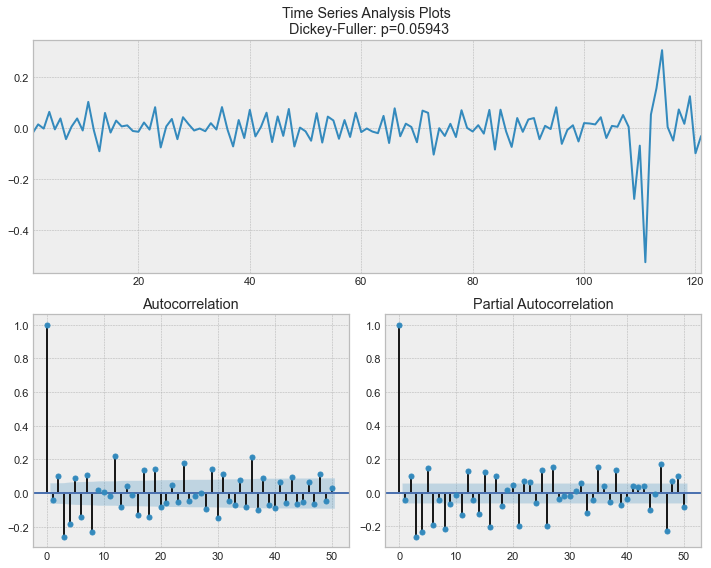

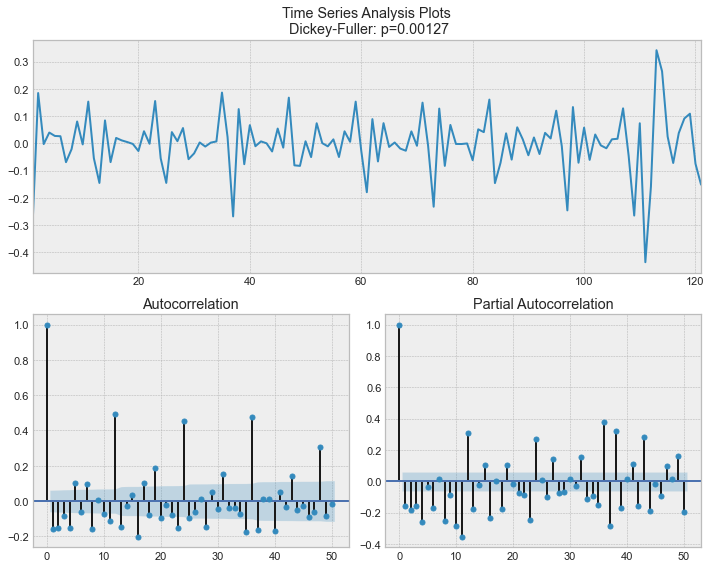

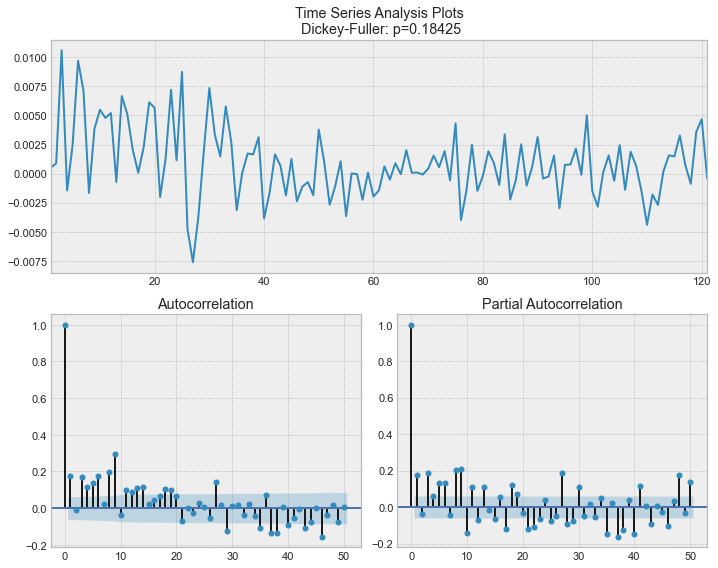

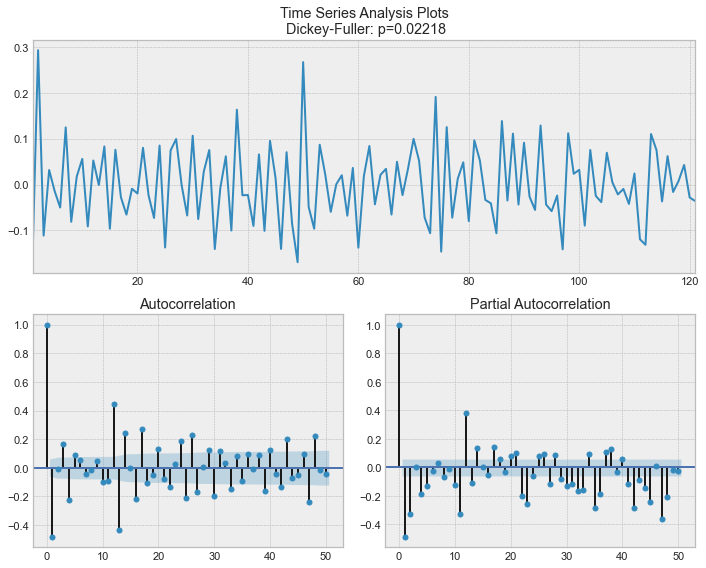

In [81]:
for column in focused_columns:
    tsplot(df[column])

## Second Order Differencing


In [88]:
df_new = df
df_new["f&b_sales"] = df_new["f&b_sales"].diff().dropna()
df_new["cpi_adjusted"] = df_new["cpi_adjusted"].diff().dropna()
df_new = df_new.dropna()

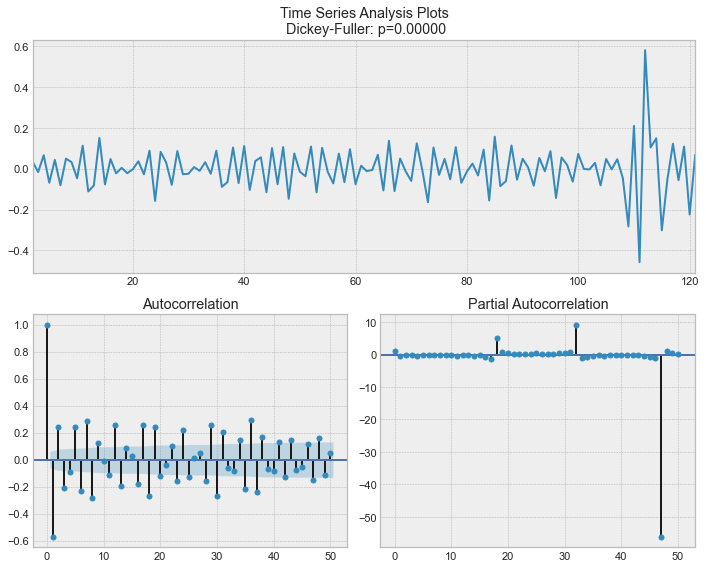

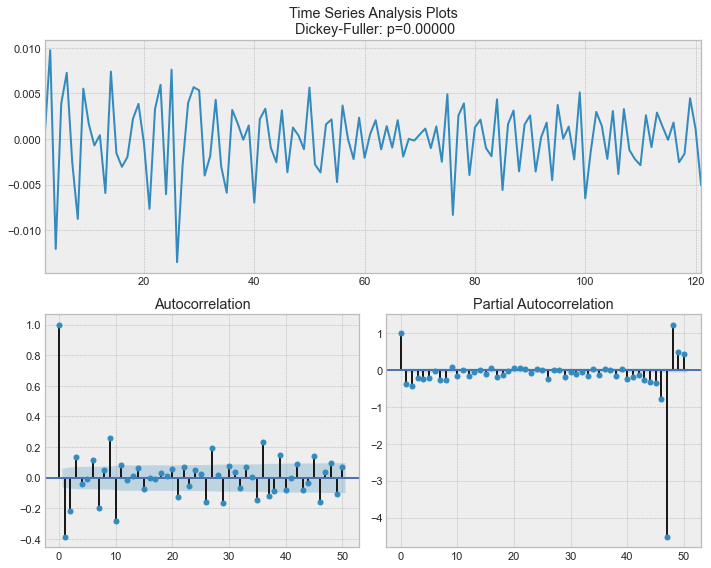

In [91]:
focused_columns2 = ["f&b_sales", "cpi_adjusted"]
for column in focused_columns2:
    tsplot(df_new[column])

In [92]:
model = VAR(df_new)
print(model.select_order(10).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -42.10      -41.96   5.187e-19      -42.04
1       -43.59     -42.56*   1.168e-19     -43.18*
2       -43.75      -41.83   1.009e-19      -42.97
3       -43.77      -40.98   9.961e-20      -42.64
4       -43.86      -40.17   9.430e-20      -42.36
5       -43.92      -39.35  9.290e-20*      -42.06
6       -43.76      -38.31   1.163e-19      -41.55
7       -43.95      -37.62   1.062e-19      -41.38
8       -44.07      -36.86   1.082e-19      -41.15
9       -44.04      -35.94   1.353e-19      -40.75
10     -44.20*      -35.21   1.484e-19      -40.55
--------------------------------------------------


In [93]:
def write_results(file_name, results, columns):
    with open(file_name,"w") as fw:
        print(results.summary(), file=fw)
        fw.write("================test_whiteness================\n")
        print(results.test_whiteness(nlags=20), file=fw)
        fw.write("================results.roots()================\n")
        for root in results.roots:
            fw.write(str(root)+",")
        fw.write("\n================is_stable================\n")
        fw.write(str(results.is_stable()))
        fw.write("\n================granger causality================\n")
        for V1 in columns:
            for V2 in columns:
                fw.write("Granger test: "+V2+"-->"+V1+"\n")
                print(results.test_causality(V1, [V2],kind='f').summary(), file=fw)
                fw.write("\n")

        fw.write("\n================long_run effects================\n")
        for effect in results.long_run_effects():
            fw.write(str(effect)+",")
        fw.write("\n================FEVD values================\n")
        print(results.fevd(20).summary,file=fw)

def structural_analyses(file_name, results, lag=20):

    # impulse response analyses
    irf = results.irf(lag)
    fig1 = irf.plot(orth=False)
    plt.savefig(file_name+"_irf_noorth.png")
    # irf.plot(impulse='V1', response="V2")
    fig2 = irf.plot_cum_effects(orth=False)
    plt.savefig(file_name+"_irf_cum_noorth.png")
    results.long_run_effects()

    # forecast error decomposition
    results.fevd(lag).plot()
    plt.savefig(file_name+"_fevd.png")
    fig1.set_figheight(20)
    fig1.set_figwidth(30)
    fig2.set_figheight(20)
    fig2.set_figwidth(30)

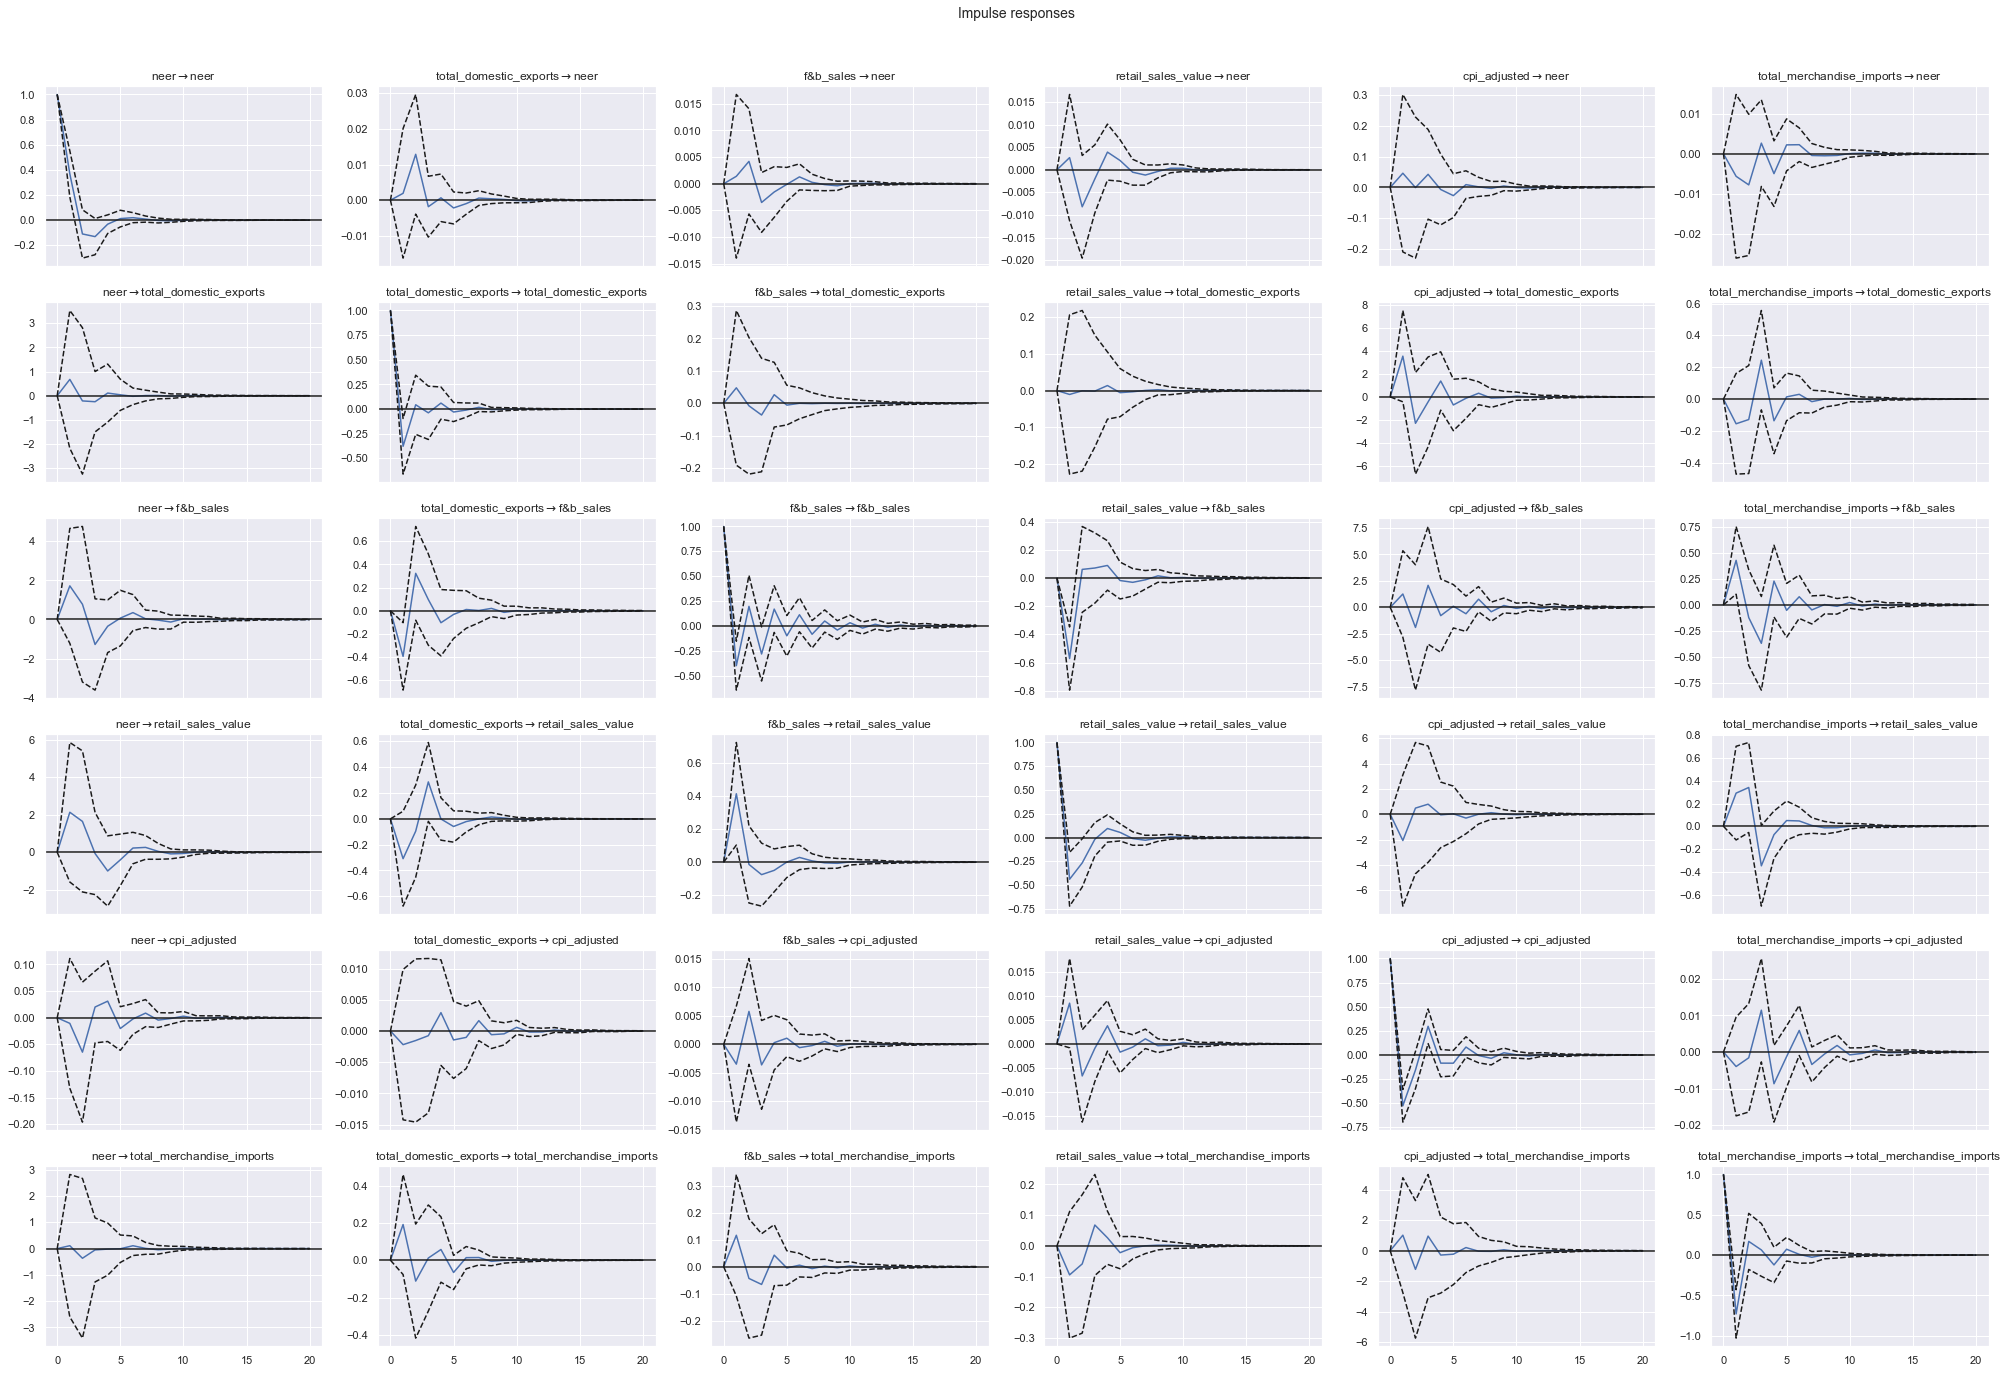

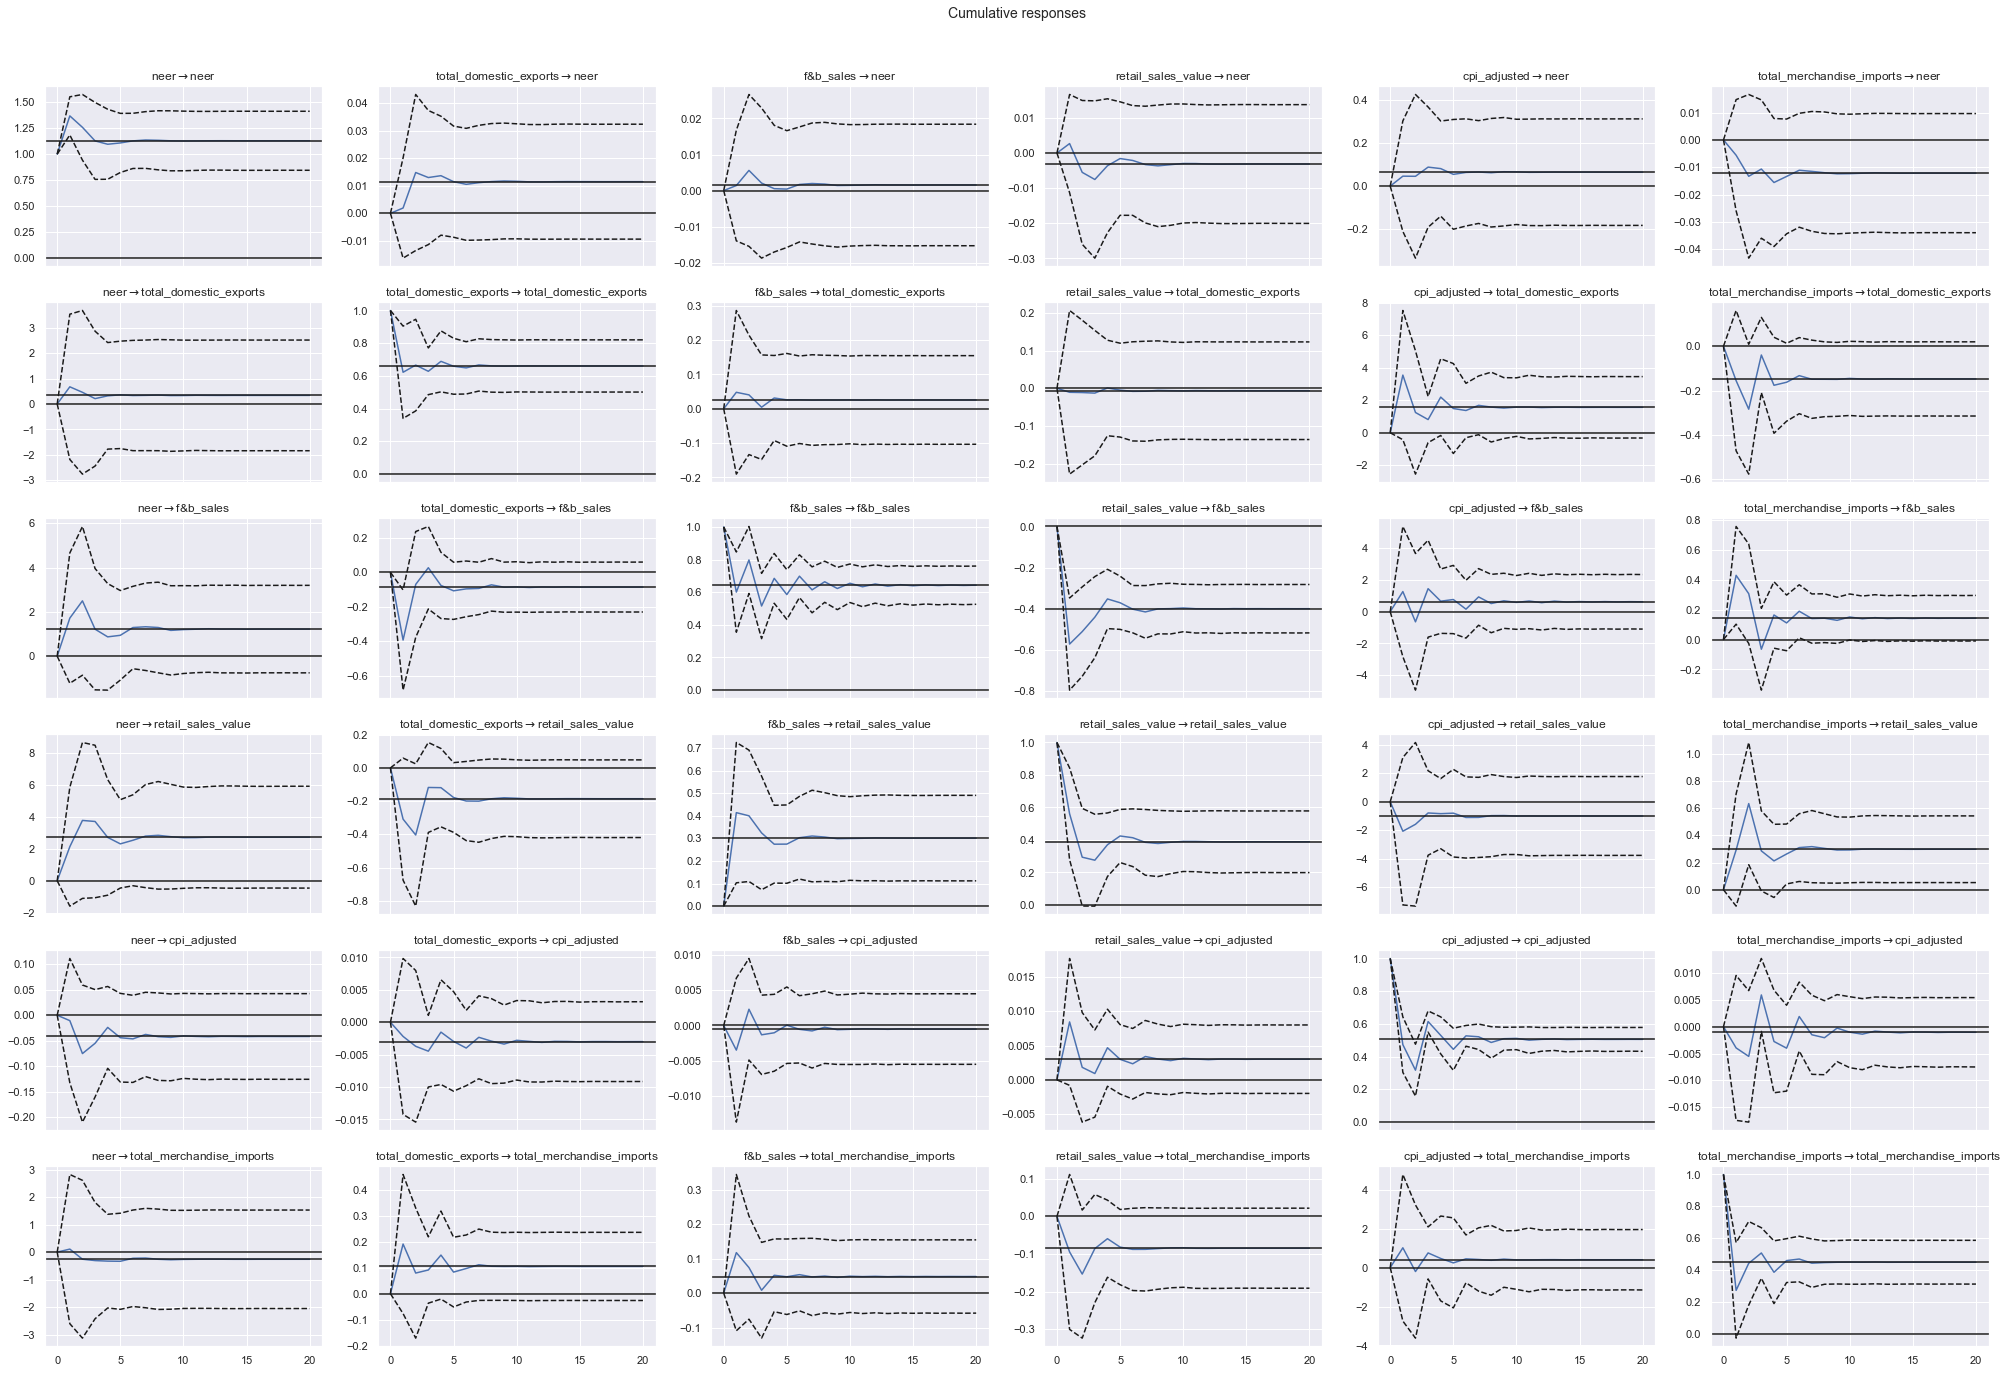

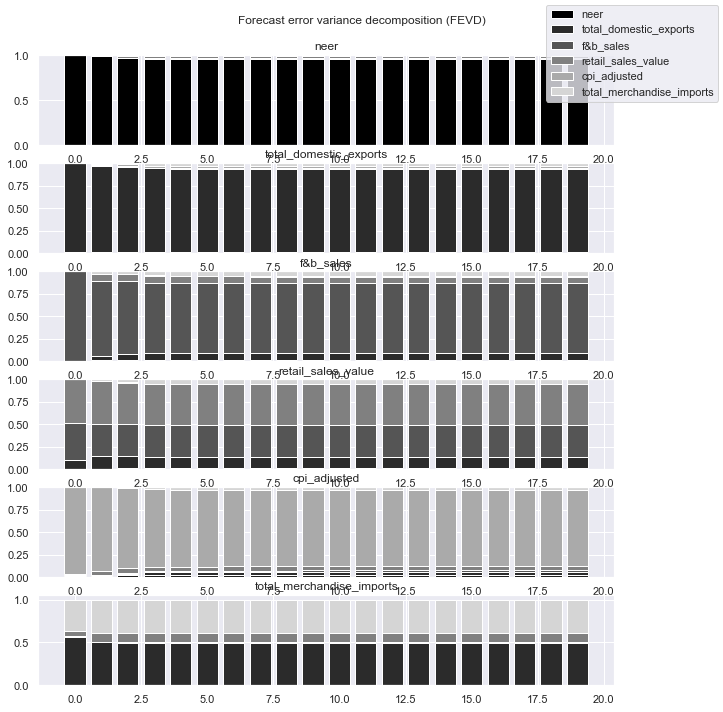

In [96]:
selected_orders = [2]
for selected_order in selected_orders:

    results = model.fit(selected_order,trend="c")
    results_file = 'results_lag'+str(selected_order)+'.txt'
    structual_file = 'lag'+str(selected_order)
    columns = df_new.columns.values.tolist()
    write_results(results_file, results, columns)
    structural_analyses(structual_file, results, 20)